In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plotting
import seaborn as sns #plotting

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.json', 'train.json']


In [2]:
# Loading the data

train_df = pd.read_json('../input/train.json')
test_df = pd.read_json('../input/test.json')

Exploring the training data
       cuisine                        ...                                                                ingredients
0        greek                        ...                          [romaine lettuce, black olives, grape tomatoes...
1  southern_us                        ...                          [plain flour, ground pepper, salt, tomatoes, g...
2     filipino                        ...                          [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian                        ...                                        [water, vegetable oil, wheat, salt]
4       indian                        ...                          [black pepper, shallots, cornflour, cayenne pe...

[5 rows x 3 columns]
(39774, 3)
Index(['cuisine', 'id', 'ingredients'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64


Text(0.5,1,'# of recipes per type of cuisine in training data')

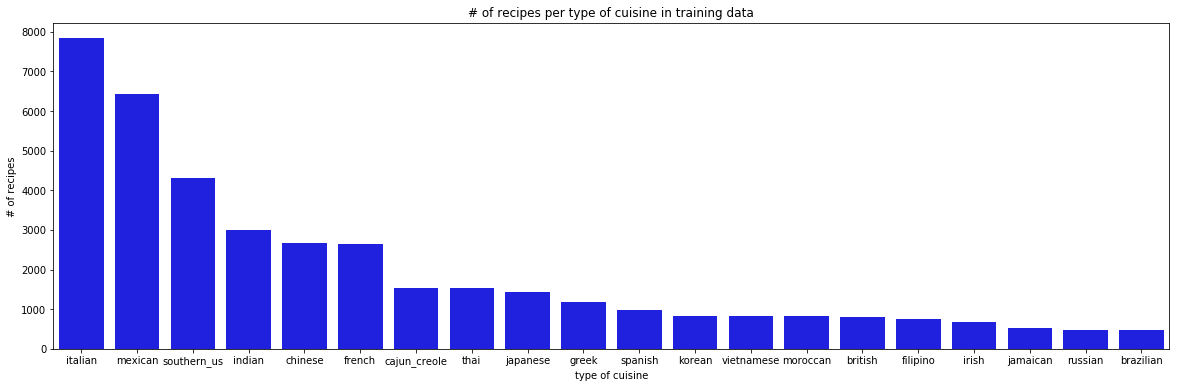

In [3]:
# Exploration

print ('Exploring the training data')
print (train_df.head(5))
print (train_df.shape)
print (train_df.columns)
print (train_df.info())

print ('-----------------------------------------------------------------------------------------------')
print ('Exploring the test data')
print (test_df.head(5))
print (test_df.shape)
print (test_df.info())

print ('-----------------------------------------------------------------------------------------------')
print ('How many cuisine types are there? How common are they in the data set?')

unique_cuisine_types = train_df['cuisine'].nunique()
print ('There are %d unique cuisine types'  %  (unique_cuisine_types))

freq_cuisines = train_df['cuisine'].value_counts()
plt.figure(figsize=(20,6))
sns.barplot(x= freq_cuisines.index, y= freq_cuisines.values, color = 'b')
plt.xlabel('type of cuisine')
plt.ylabel('# of recipes')
plt.title('# of recipes per type of cuisine in training data')

From briefly looking at the training and test data we can see that:
1. The 'ingredients' column has a list of ingredients delimited by ','. We will have to deal with this when we tokenize the data. 
2. We can also spot  non-important words such as 'of' (in 'cream of tartar' which could be removed as they will not likely be linked to any particular cuisine
3. There is a trade-off in tokenizing whole phrases, or individual words. Let's try individual words first..

There are also 20 cuisine types, with italian being the most popular, and brazilian being the least popular. 

Now let's look at how many ingredients we might be working with...

The average number of ingredients is 10
The max number of ingredients is 65
The min number of ingredients is 1


Text(0.5,1,'spread of # of ingredients by type of cuisine, ordered by range in # of ingredients')

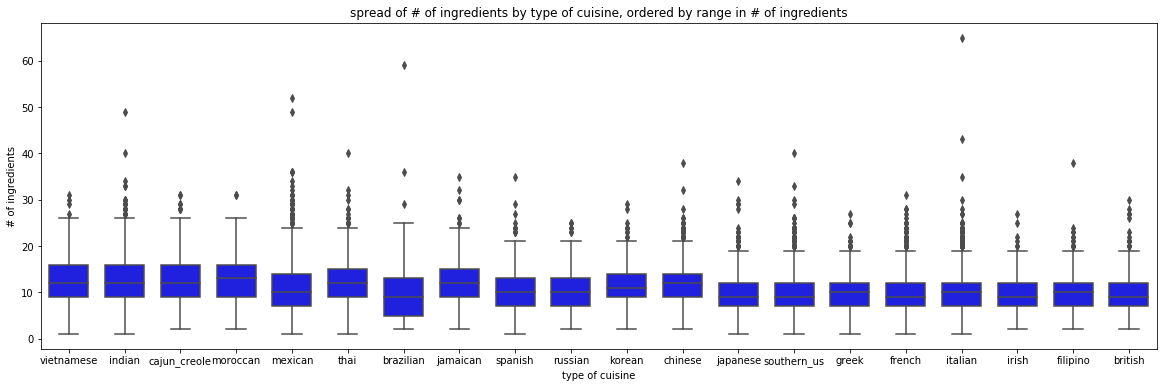

In [4]:
# Exploration continued...

# 1. Counting the number of ingredients in each recipe list
number_of_ingredients = []
for i in range(len(train_df['ingredients'])):
    number_of_ingredients.append(len(train_df['ingredients'][i]))

train_df['number_of_ingredients'] = number_of_ingredients

print ('The average number of ingredients is %d' % np.average(number_of_ingredients))
print ('The max number of ingredients is %d' % np.max(number_of_ingredients))
print ('The min number of ingredients is %d' % np.min(number_of_ingredients))

# What do the ranges of # of ingredients look like for the different cuisines?

# Getting the min and max values of the boxplots to order it by size of range
lowIQ = train_df.groupby(['cuisine']).quantile(0.25)['number_of_ingredients']
highIQ = train_df.groupby(['cuisine']).quantile(0.75)['number_of_ingredients']
IQR = highIQ - lowIQ
minvalue = train_df.groupby(['cuisine']).min()['number_of_ingredients']
maxvalue = highIQ + (IQR * 1.5)
overall_range = maxvalue - minvalue
ordered_cuisines = (overall_range.sort_values(ascending = False).index)

plt.figure(figsize=(20,6))
sns.boxplot(x="cuisine", y="number_of_ingredients",data= train_df, width = 0.7, color = 'b', order = ordered_cuisines)
plt.xlabel('type of cuisine')
plt.ylabel('# of ingredients')
plt.title('spread of # of ingredients by type of cuisine, ordered by range in # of ingredients')

The average number of ingredients is 10 but there is a huge range in all cuisine types, ranging from 65 to 1.

As you would expect... the British range excluding outliers has a maximum value which is relatively low whilst Vietnamese and Indian cuisines appear to use many more ingredients. 

.... Now let's turn the data into something we can work with for predictions and create our test and training data sets

In [5]:
# Turn the ingredients into a single string so we can process them as individual words, as important words may be more easily recognised as common between 
# recipes.
train_df['seperated_ingredients'] = train_df['ingredients'].apply(','.join)
test_df['seperated_ingredients'] = test_df['ingredients'].apply(','.join)

# We also need to turn the cuisines into numbers for our neural networks later...
train_df['cuisine'] = pd.Categorical(train_df['cuisine'])

#To capture the category codes in a column for one-hot-encoding later (using keras.utils.to_categorical)
train_df['cuisine_code'] = train_df.cuisine.cat.codes



In [6]:
#Splitting the training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['seperated_ingredients'], train_df['cuisine_code'], test_size = 0.30, random_state = 102)

To predict the cuisine types for the test data, I will use both CountVectorizer.

CountVectorizer simply counts the number of text tokens and puts them in a matrix. 

There will also be several conditions within the vectorization steps: 
1) Lemmatizing the words so that similar words can be recognised e.g. olives and olive
2) Removing stopwords such as 'the' and 'and' which will likely not be linked to any cuisine type and will contribute to noise
3) Tokenizing on words only with a token pattern, ignoring any numbers which again will likely just be noise. 
4) Ensuring all words are lowercase as capslock can interfere with matching. 



In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
       def __init__(self):
            self.wnl = WordNetLemmatizer()
       def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
pattern = r"[A-Za-z]"
from keras.utils import np_utils   

vec = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words = 'english', lowercase = True, token_pattern = pattern, ngram_range = (1,1))
training_predictors = vec.fit_transform(train_df['seperated_ingredients'])
n_cols = training_predictors.shape[1]
# print (training_predictors) - need to find out what word id 9 is as it appears a lot in the first row..
training_targets = np_utils.to_categorical(train_df['cuisine_code']) #y_train needs to be a list of numbers corresponding to cuisines
#print (training_targets)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [8]:
#Using neural networks

#Imports
import keras
from keras.layers import Dense , Dropout#
from keras.models import Sequential #
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience = 3)

# Set up the model: model
def get_model(dropout = 0.4):
    model = Sequential()
    # Add the first layer
    model.add(Dense(1000, activation = 'relu', input_shape=(n_cols,)))
    model.add(Dropout(dropout))
    # Add a second layer
    model.add(Dense(1000, activation = 'relu'))
    model.add(Dropout(dropout))
    # Add a third layer
    model.add(Dense(1000, activation = 'softmax'))
    model.add(Dropout(dropout))
    # Add the output layer
    model.add(Dense(20))
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

model_nn = get_model()
# Fit the model
model_nn.fit(training_predictors, training_targets,batch_size=300, epochs=10, validation_split = 0.3, callbacks = [early_stopping_monitor])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              3014000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                20020     
Total para

In [9]:
# Best score so far is: 0.74030 

In [10]:
# Writing the test submission file 
submission = pl.predict(test_df['seperated_ingredients'])

submission_file = pd.DataFrame(data = submission, columns = ['cuisine'], index = test_df['id'])

submission_file.reset_index(level=0, inplace=True)

print (submission_file.head(5))
submission_file.to_csv('submission4.csv', index = False)

NameError: name 'pl' is not defined